In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2549028/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                             | 0/60000 [00:00<?, ?it/s]

 12%|█████████████▌                                                                                                 | 7346/60000 [00:00<00:00, 73454.47it/s]

 24%|██████████████████████████▉                                                                                   | 14692/60000 [00:00<00:00, 72050.51it/s]

 37%|████████████████████████████████████████▍                                                                     | 22081/60000 [00:00<00:00, 72881.03it/s]

 49%|█████████████████████████████████████████████████████▉                                                        | 29402/60000 [00:00<00:00, 73006.55it/s]

 61%|███████████████████████████████████████████████████████████████████▎                                          | 36704/60000 [00:00<00:00, 72418.33it/s]

 73%|████████████████████████████████████████████████████████████████████████████████▌                             | 43948/60000 [00:00<00:00, 72062.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                | 51265/60000 [00:00<00:00, 72420.27it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 58612/60000 [00:00<00:00, 72752.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 72460.51it/s]

  0%|                                                                                                                             | 0/10000 [00:00<?, ?it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▋                               | 7182/10000 [00:00<00:00, 71811.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 68789.98it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 kba5ntt5


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                               | 0/192 [00:00<?, ?it/s]

  1%|▌                                                                                                                      | 1/192 [00:00<01:30,  2.12it/s]

  3%|███                                                                                                                    | 5/192 [00:00<00:17, 10.69it/s]

  5%|█████▌                                                                                                                 | 9/192 [00:00<00:10, 17.51it/s]

  7%|███████▉                                                                                                              | 13/192 [00:00<00:07, 22.74it/s]

  9%|██████████▍                                                                                                           | 17/192 [00:00<00:06, 26.66it/s]

 11%|████████████▉                                                                                                         | 21/192 [00:01<00:05, 29.54it/s]

 13%|███████████████▎                                                                                                      | 25/192 [00:01<00:05, 31.63it/s]

 15%|█████████████████▊                                                                                                    | 29/192 [00:01<00:04, 33.13it/s]

 17%|████████████████████▎                                                                                                 | 33/192 [00:01<00:04, 34.19it/s]

 19%|██████████████████████▋                                                                                               | 37/192 [00:01<00:04, 34.96it/s]

 21%|█████████████████████████▏                                                                                            | 41/192 [00:01<00:04, 35.48it/s]

 23%|███████████████████████████▋                                                                                          | 45/192 [00:01<00:04, 35.86it/s]

 26%|██████████████████████████████                                                                                        | 49/192 [00:01<00:03, 36.12it/s]

 28%|████████████████████████████████▌                                                                                     | 53/192 [00:01<00:03, 36.32it/s]

 30%|███████████████████████████████████                                                                                   | 57/192 [00:01<00:03, 36.44it/s]

 32%|█████████████████████████████████████▍                                                                                | 61/192 [00:02<00:03, 36.54it/s]

 34%|███████████████████████████████████████▉                                                                              | 65/192 [00:02<00:03, 36.59it/s]

 36%|██████████████████████████████████████████▍                                                                           | 69/192 [00:02<00:03, 36.65it/s]

 38%|████████████████████████████████████████████▊                                                                         | 73/192 [00:02<00:03, 36.66it/s]

 40%|███████████████████████████████████████████████▎                                                                      | 77/192 [00:02<00:03, 36.70it/s]

 42%|█████████████████████████████████████████████████▊                                                                    | 81/192 [00:02<00:03, 36.73it/s]

 44%|████████████████████████████████████████████████████▏                                                                 | 85/192 [00:02<00:02, 36.71it/s]

 46%|██████████████████████████████████████████████████████▋                                                               | 89/192 [00:02<00:02, 36.72it/s]

 48%|█████████████████████████████████████████████████████████▏                                                            | 93/192 [00:02<00:02, 36.73it/s]

 51%|███████████████████████████████████████████████████████████▌                                                          | 97/192 [00:03<00:02, 36.72it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                       | 101/192 [00:03<00:02, 36.74it/s]

 55%|███████████████████████████████████████████████████████████████▉                                                     | 105/192 [00:03<00:02, 36.75it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                  | 109/192 [00:03<00:02, 36.73it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                                | 113/192 [00:03<00:02, 36.68it/s]

 61%|███████████████████████████████████████████████████████████████████████▎                                             | 117/192 [00:03<00:02, 36.71it/s]

 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 121/192 [00:03<00:01, 36.68it/s]

 65%|████████████████████████████████████████████████████████████████████████████▏                                        | 125/192 [00:03<00:01, 36.70it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▌                                      | 129/192 [00:03<00:01, 36.73it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████                                    | 133/192 [00:04<00:01, 36.74it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 137/192 [00:04<00:01, 36.73it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 141/192 [00:04<00:01, 36.75it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 145/192 [00:04<00:01, 36.75it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                          | 149/192 [00:04<00:01, 36.76it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 153/192 [00:04<00:01, 36.77it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                     | 157/192 [00:04<00:00, 36.72it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 161/192 [00:04<00:00, 36.73it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 165/192 [00:04<00:00, 36.73it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 169/192 [00:05<00:00, 36.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 173/192 [00:05<00:00, 36.74it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 177/192 [00:05<00:00, 36.74it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 181/192 [00:05<00:00, 36.74it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 185/192 [00:05<00:00, 36.66it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 189/192 [00:05<00:00, 36.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:05<00:00, 33.47it/s]

train - OK


  0%|                                                                                                                                | 0/48 [00:00<?, ?it/s]

  4%|█████                                                                                                                   | 2/48 [00:00<00:02, 17.28it/s]

 12%|███████████████                                                                                                         | 6/48 [00:00<00:01, 28.08it/s]

 21%|████████████████████████▊                                                                                              | 10/48 [00:00<00:01, 31.81it/s]

 29%|██████████████████████████████████▋                                                                                    | 14/48 [00:00<00:01, 33.69it/s]

 38%|████████████████████████████████████████████▋                                                                          | 18/48 [00:00<00:00, 34.78it/s]

 46%|██████████████████████████████████████████████████████▌                                                                | 22/48 [00:00<00:00, 35.45it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                      | 26/48 [00:00<00:00, 35.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████▍                                            | 30/48 [00:00<00:00, 36.16it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 34/48 [00:00<00:00, 36.34it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▏                        | 38/48 [00:01<00:00, 36.46it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 42/48 [00:01<00:00, 36.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 46/48 [00:01<00:00, 36.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.76it/s]

val - OK


  0%|                                                                                                                                | 0/41 [00:00<?, ?it/s]

  5%|█████▊                                                                                                                  | 2/41 [00:00<00:02, 17.23it/s]

 15%|█████████████████▌                                                                                                      | 6/41 [00:00<00:01, 28.23it/s]

 24%|█████████████████████████████                                                                                          | 10/41 [00:00<00:00, 32.00it/s]

 34%|████████████████████████████████████████▋                                                                              | 14/41 [00:00<00:00, 33.82it/s]

 44%|████████████████████████████████████████████████████▏                                                                  | 18/41 [00:00<00:00, 34.85it/s]

 54%|███████████████████████████████████████████████████████████████▊                                                       | 22/41 [00:00<00:00, 35.46it/s]

 63%|███████████████████████████████████████████████████████████████████████████▍                                           | 26/41 [00:00<00:00, 35.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                | 30/41 [00:00<00:00, 36.12it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 34/41 [00:00<00:00, 36.29it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 38/41 [00:01<00:00, 36.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.12it/s]

test InD - OK


  0%|                                                                                                                               | 0/268 [00:00<?, ?it/s]

  1%|▉                                                                                                                      | 2/268 [00:00<00:16, 16.62it/s]

  2%|██▋                                                                                                                    | 6/268 [00:00<00:09, 27.83it/s]

  4%|████▍                                                                                                                 | 10/268 [00:00<00:08, 31.77it/s]

  5%|██████▏                                                                                                               | 14/268 [00:00<00:07, 33.69it/s]

  7%|███████▉                                                                                                              | 18/268 [00:00<00:07, 34.78it/s]

  8%|█████████▋                                                                                                            | 22/268 [00:00<00:06, 35.45it/s]

 10%|███████████▍                                                                                                          | 26/268 [00:00<00:06, 35.88it/s]

 11%|█████████████▏                                                                                                        | 30/268 [00:00<00:06, 36.15it/s]

 13%|██████████████▉                                                                                                       | 34/268 [00:00<00:06, 36.34it/s]

 14%|████████████████▋                                                                                                     | 38/268 [00:01<00:06, 36.46it/s]

 16%|██████████████████▍                                                                                                   | 42/268 [00:01<00:06, 36.56it/s]

 17%|████████████████████▎                                                                                                 | 46/268 [00:01<00:06, 36.62it/s]

 19%|██████████████████████                                                                                                | 50/268 [00:01<00:05, 36.66it/s]

 20%|███████████████████████▊                                                                                              | 54/268 [00:01<00:05, 36.70it/s]

 22%|█████████████████████████▌                                                                                            | 58/268 [00:01<00:05, 36.71it/s]

 23%|███████████████████████████▎                                                                                          | 62/268 [00:01<00:05, 36.74it/s]

 25%|█████████████████████████████                                                                                         | 66/268 [00:01<00:05, 36.61it/s]

 26%|██████████████████████████████▊                                                                                       | 70/268 [00:01<00:05, 36.65it/s]

 28%|████████████████████████████████▌                                                                                     | 74/268 [00:02<00:05, 36.67it/s]

 29%|██████████████████████████████████▎                                                                                   | 78/268 [00:02<00:05, 36.70it/s]

 31%|████████████████████████████████████                                                                                  | 82/268 [00:02<00:05, 36.73it/s]

 32%|█████████████████████████████████████▊                                                                                | 86/268 [00:02<00:04, 36.72it/s]

 34%|███████████████████████████████████████▋                                                                              | 90/268 [00:02<00:04, 36.74it/s]

 35%|█████████████████████████████████████████▍                                                                            | 94/268 [00:02<00:04, 36.73it/s]

 37%|███████████████████████████████████████████▏                                                                          | 98/268 [00:02<00:04, 36.74it/s]

 38%|████████████████████████████████████████████▌                                                                        | 102/268 [00:02<00:04, 36.76it/s]

 40%|██████████████████████████████████████████████▎                                                                      | 106/268 [00:02<00:04, 36.74it/s]

 41%|████████████████████████████████████████████████                                                                     | 110/268 [00:03<00:04, 36.76it/s]

 43%|█████████████████████████████████████████████████▊                                                                   | 114/268 [00:03<00:04, 36.76it/s]

 44%|███████████████████████████████████████████████████▌                                                                 | 118/268 [00:03<00:04, 36.74it/s]

 46%|█████████████████████████████████████████████████████▎                                                               | 122/268 [00:03<00:03, 36.72it/s]

 47%|███████████████████████████████████████████████████████                                                              | 126/268 [00:03<00:03, 36.75it/s]

 49%|████████████████████████████████████████████████████████▊                                                            | 130/268 [00:03<00:03, 36.76it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 134/268 [00:03<00:03, 36.77it/s]

 51%|████████████████████████████████████████████████████████████▏                                                        | 138/268 [00:03<00:03, 36.76it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                       | 142/268 [00:03<00:03, 36.77it/s]

 54%|███████████████████████████████████████████████████████████████▋                                                     | 146/268 [00:04<00:03, 36.77it/s]

 56%|█████████████████████████████████████████████████████████████████▍                                                   | 150/268 [00:04<00:03, 36.76it/s]

 57%|███████████████████████████████████████████████████████████████████▏                                                 | 154/268 [00:04<00:03, 36.74it/s]

 59%|████████████████████████████████████████████████████████████████████▉                                                | 158/268 [00:04<00:02, 36.76it/s]

 60%|██████████████████████████████████████████████████████████████████████▋                                              | 162/268 [00:04<00:02, 36.76it/s]

 62%|████████████████████████████████████████████████████████████████████████▍                                            | 166/268 [00:04<00:02, 36.76it/s]

 63%|██████████████████████████████████████████████████████████████████████████▏                                          | 170/268 [00:04<00:02, 36.77it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                         | 174/268 [00:04<00:02, 36.71it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 178/268 [00:04<00:02, 36.75it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▍                                     | 182/268 [00:05<00:02, 36.76it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 186/268 [00:05<00:02, 36.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 190/268 [00:05<00:02, 36.77it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 194/268 [00:05<00:02, 36.77it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 198/268 [00:05<00:01, 36.74it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▏                            | 202/268 [00:05<00:01, 36.76it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▉                           | 206/268 [00:05<00:01, 36.76it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 210/268 [00:05<00:01, 36.77it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▍                       | 214/268 [00:05<00:01, 36.77it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                     | 218/268 [00:05<00:01, 36.77it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 222/268 [00:06<00:01, 35.99it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 226/268 [00:06<00:01, 36.17it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 230/268 [00:06<00:01, 36.35it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 234/268 [00:06<00:00, 36.48it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 238/268 [00:06<00:00, 36.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 242/268 [00:06<00:00, 36.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 246/268 [00:06<00:00, 36.67it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 250/268 [00:06<00:00, 36.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 254/268 [00:06<00:00, 36.71it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 258/268 [00:07<00:00, 36.73it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 262/268 [00:07<00:00, 36.75it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 266/268 [00:07<00:00, 36.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:07<00:00, 36.11it/s]

test OoD - OK


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

  4%|████▊                                                                                                                  | 4/100 [00:00<00:02, 36.83it/s]

  8%|█████████▌                                                                                                             | 8/100 [00:00<00:02, 36.84it/s]

 12%|██████████████▏                                                                                                       | 12/100 [00:00<00:02, 36.83it/s]

 16%|██████████████████▉                                                                                                   | 16/100 [00:00<00:02, 36.84it/s]

 20%|███████████████████████▌                                                                                              | 20/100 [00:00<00:02, 36.85it/s]

 24%|████████████████████████████▎                                                                                         | 24/100 [00:00<00:02, 36.85it/s]

 28%|█████████████████████████████████                                                                                     | 28/100 [00:00<00:01, 36.86it/s]

 32%|█████████████████████████████████████▊                                                                                | 32/100 [00:00<00:01, 36.86it/s]

 36%|██████████████████████████████████████████▍                                                                           | 36/100 [00:00<00:01, 36.87it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 40/100 [00:01<00:01, 36.86it/s]

 44%|███████████████████████████████████████████████████▉                                                                  | 44/100 [00:01<00:01, 36.85it/s]

 48%|████████████████████████████████████████████████████████▋                                                             | 48/100 [00:01<00:01, 36.87it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                        | 52/100 [00:01<00:01, 36.87it/s]

 56%|██████████████████████████████████████████████████████████████████                                                    | 56/100 [00:01<00:01, 36.85it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 60/100 [00:01<00:01, 36.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████▌                                          | 64/100 [00:01<00:00, 36.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 68/100 [00:01<00:00, 36.84it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 72/100 [00:01<00:00, 36.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 76/100 [00:02<00:00, 36.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 80/100 [00:02<00:00, 36.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 84/100 [00:02<00:00, 36.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 88/100 [00:02<00:00, 36.85it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 92/100 [00:02<00:00, 36.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [00:02<00:00, 36.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.85it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(24476, 1, 32, 32) (24476, 1, 32, 32) (24476, 256) (24476, 5) (24476,)
(6120, 1, 32, 32) (6120, 1, 32, 32) (6120, 256) (6120, 5) (6120,)
(5139, 1, 32, 32) (5139, 1, 32, 32) (5139, 256) (5139, 5) (5139,)
(34265, 1, 32, 32) (34265, 1, 32, 32) (34265, 256) (34265, 5) (34265,)
(12800, 1, 32, 32) (12800, 1, 32, 32) (12800, 256) (12800, 5)


In [11]:
# create tsne embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb_fpi2d = tsne.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    all_lgt_fpi2d = tsne.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

(5139, 2) (34265, 2)


(5139, 2) (34265, 2)


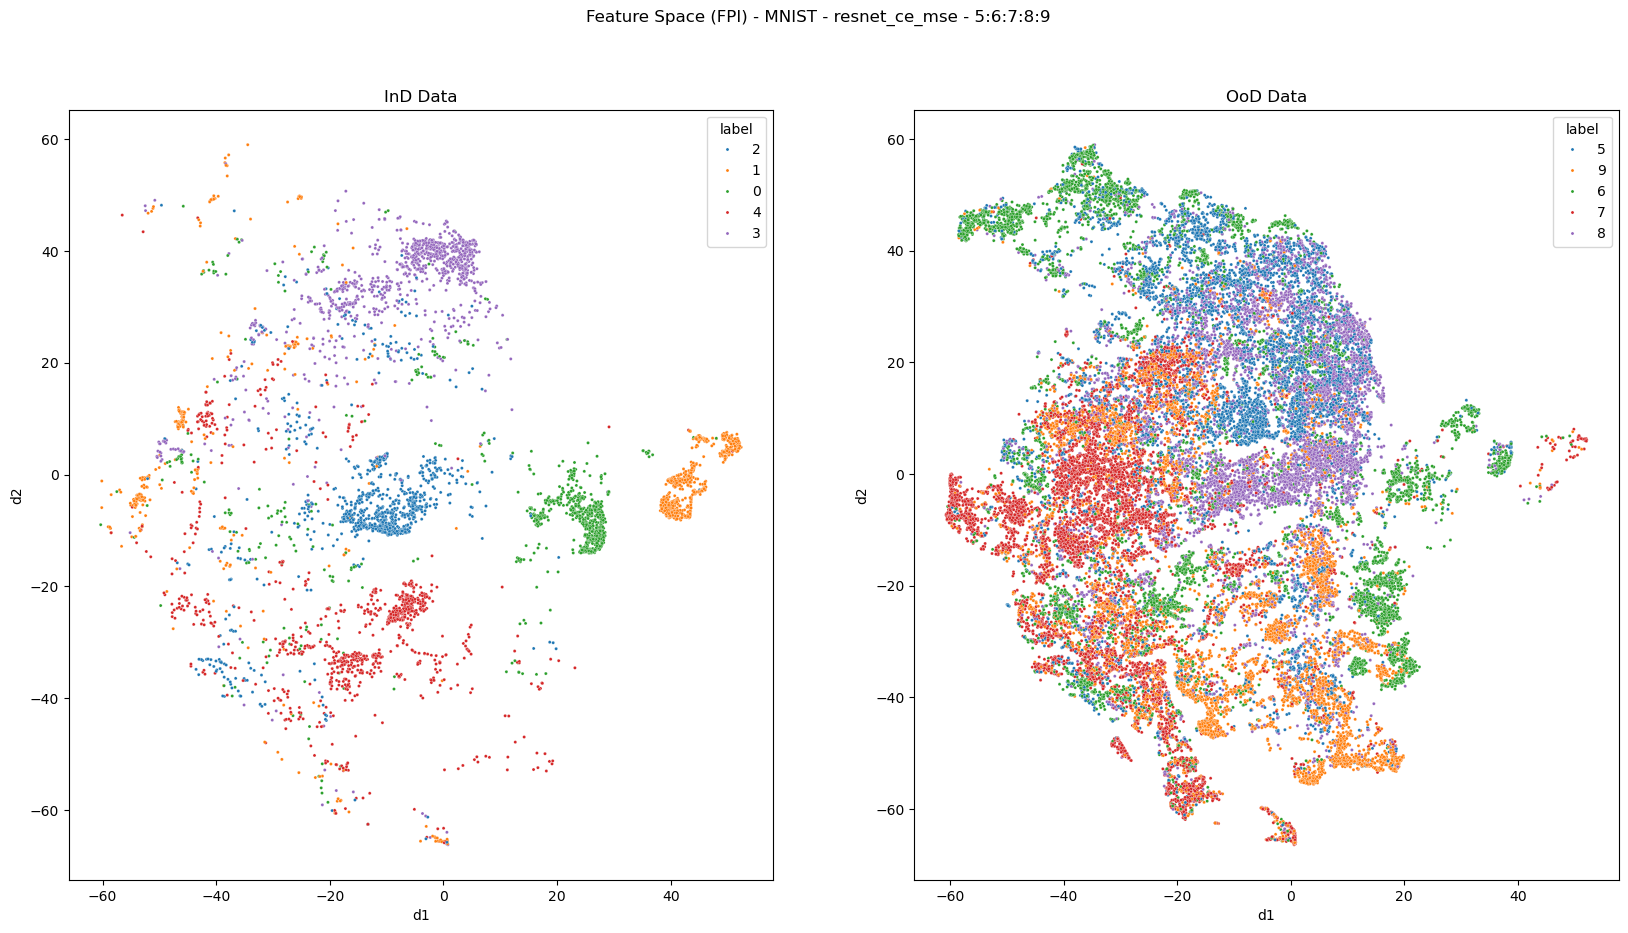

In [12]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

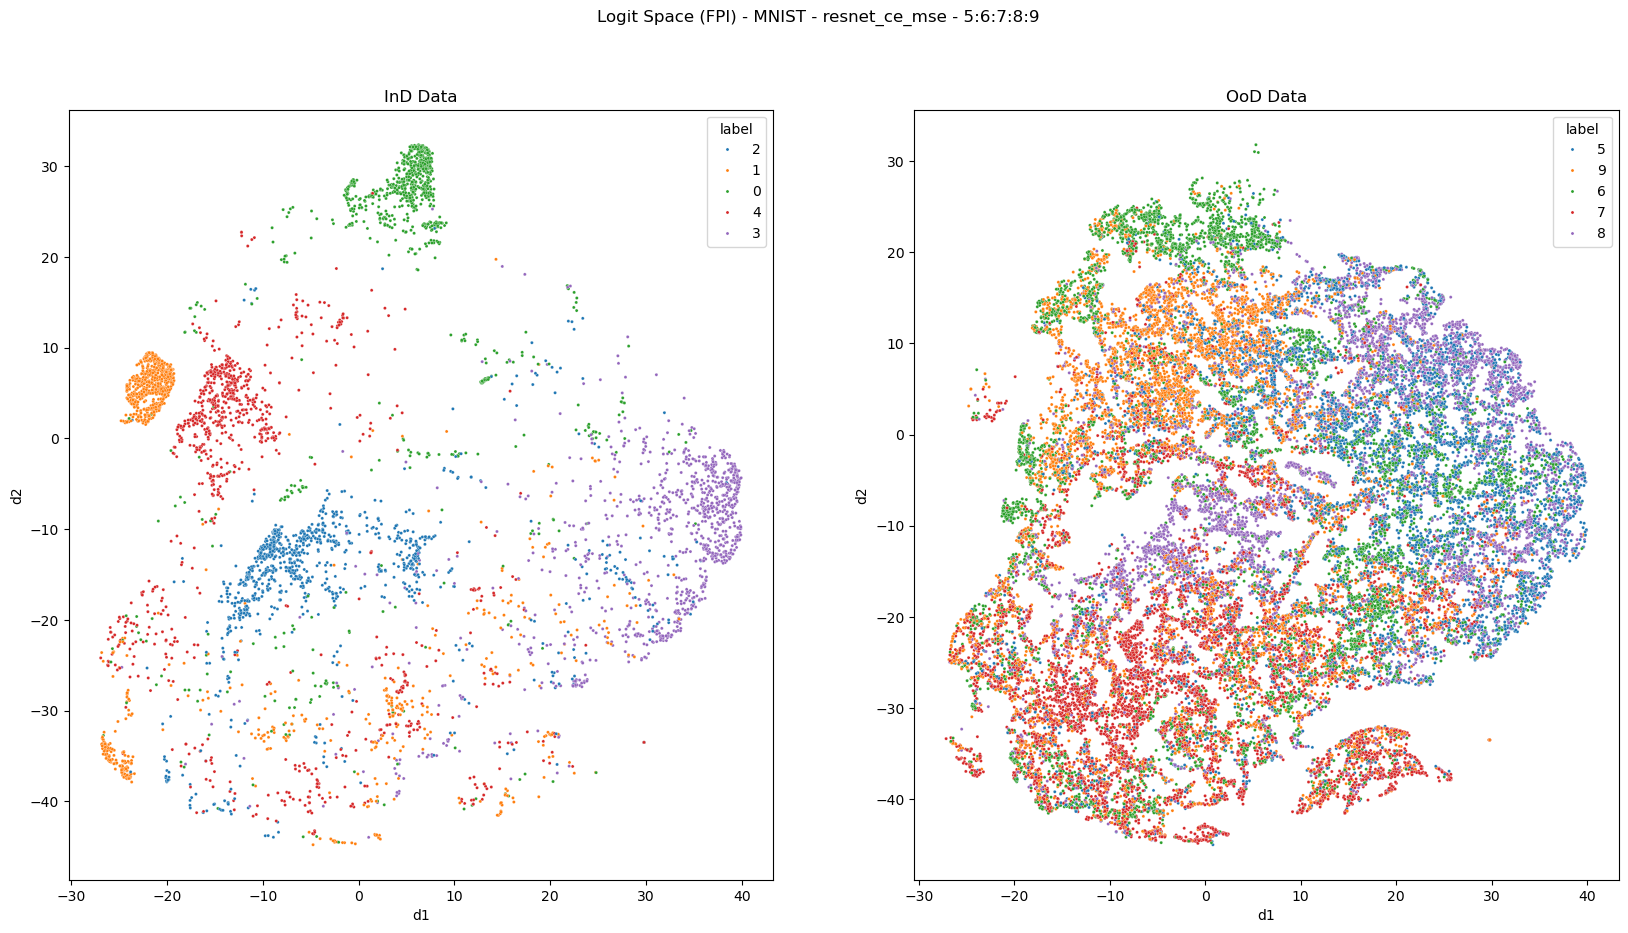

In [13]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:01<00:03,  1.21s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:02<00:02,  1.15s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:03<00:01,  1.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.22s/it]

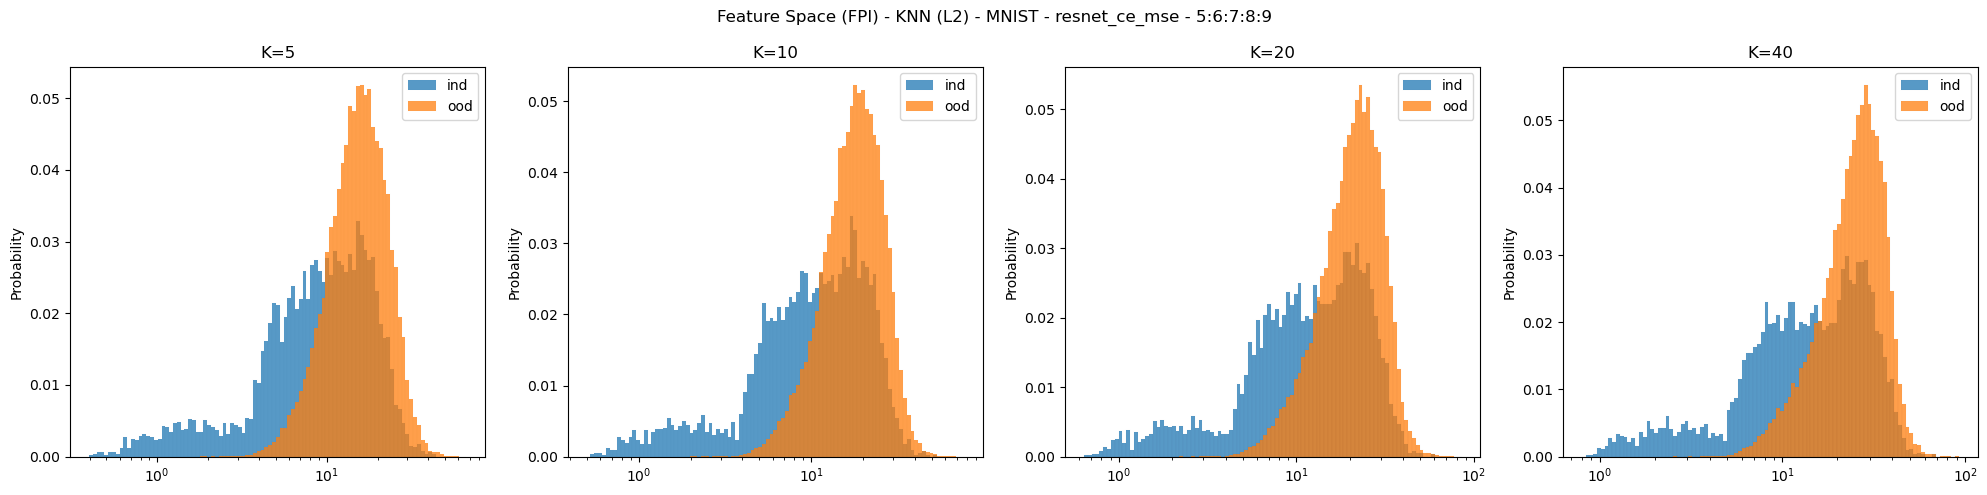

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:01<00:03,  1.03s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:02<00:02,  1.16s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:03<00:01,  1.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]

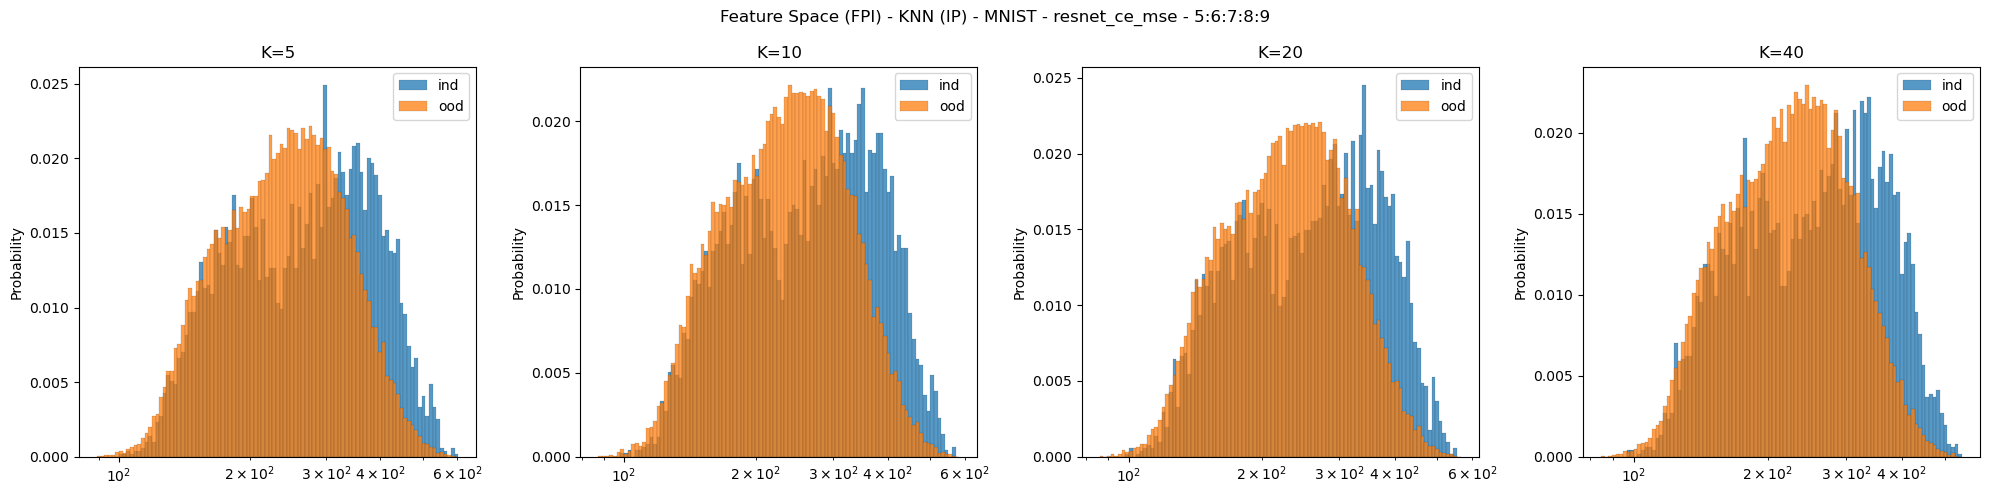

In [15]:
# check knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:01<00:03,  1.07s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:02<00:02,  1.10s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:03<00:01,  1.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.23s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.19s/it]

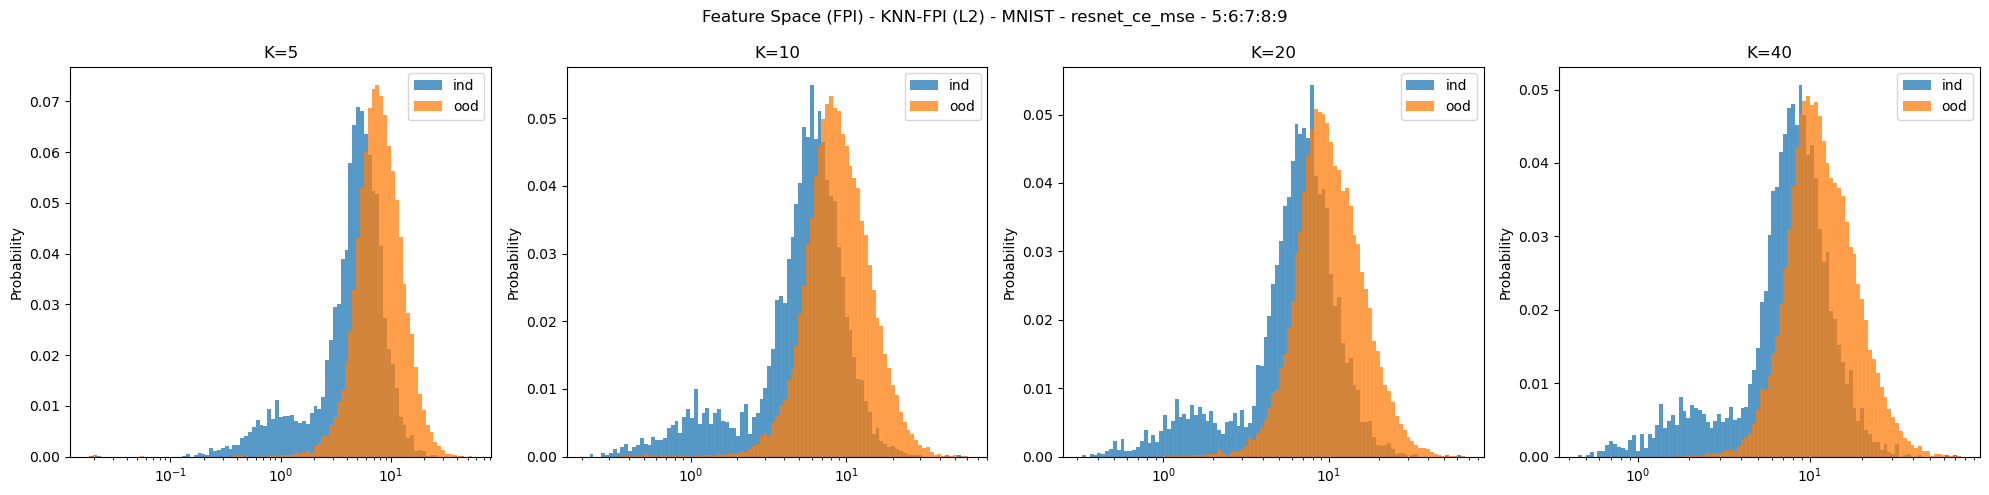

In [16]:
# check knn to val data FPI in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:01<00:03,  1.22s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:02<00:02,  1.13s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:03<00:01,  1.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.22s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.20s/it]

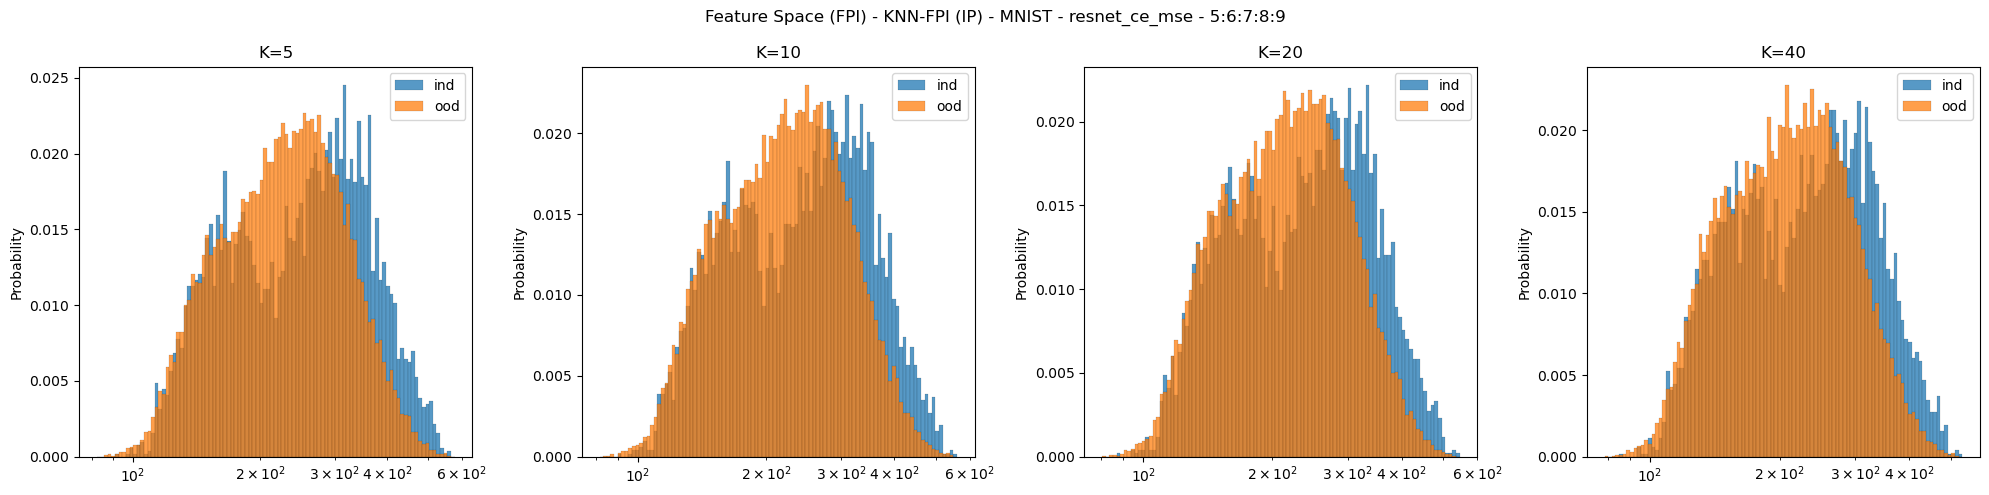

In [17]:
# check knn to val data FPI in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:01,  2.70it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  2.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  2.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]

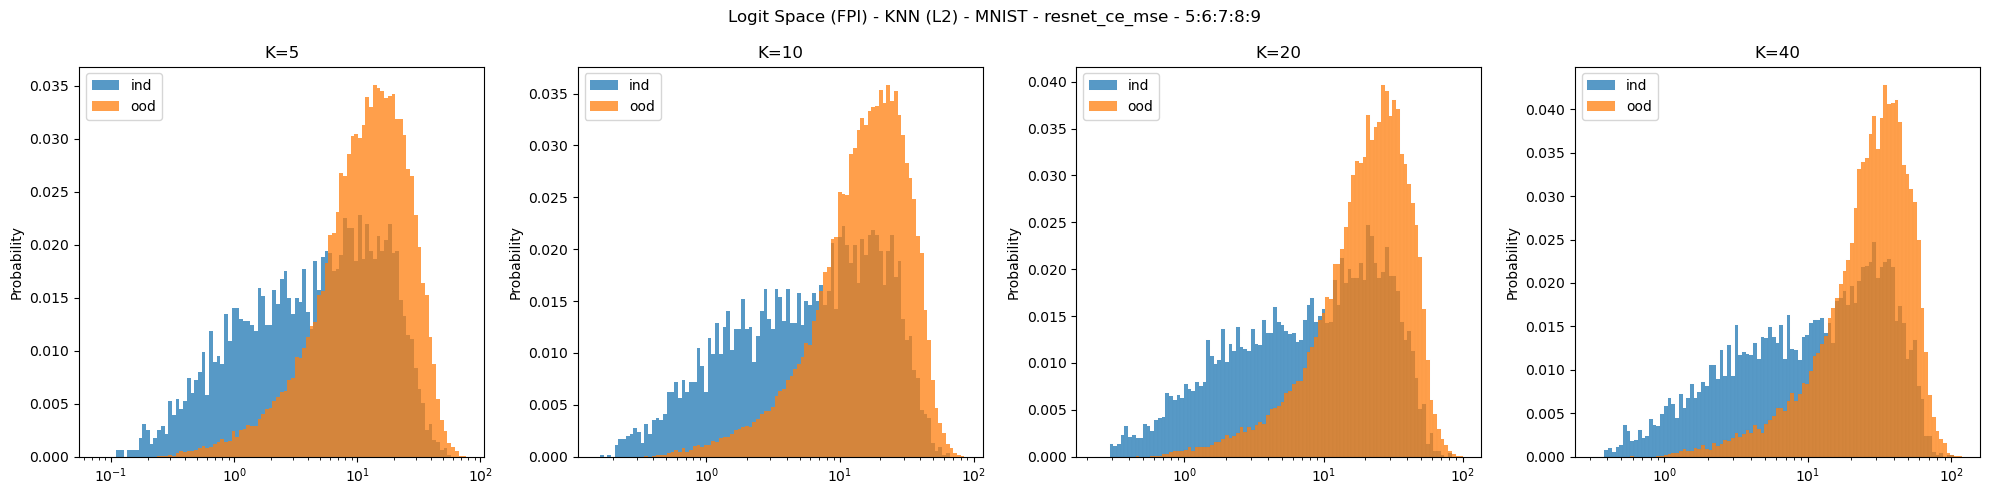

In [18]:
# check knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:01,  2.90it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  2.71it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  2.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]

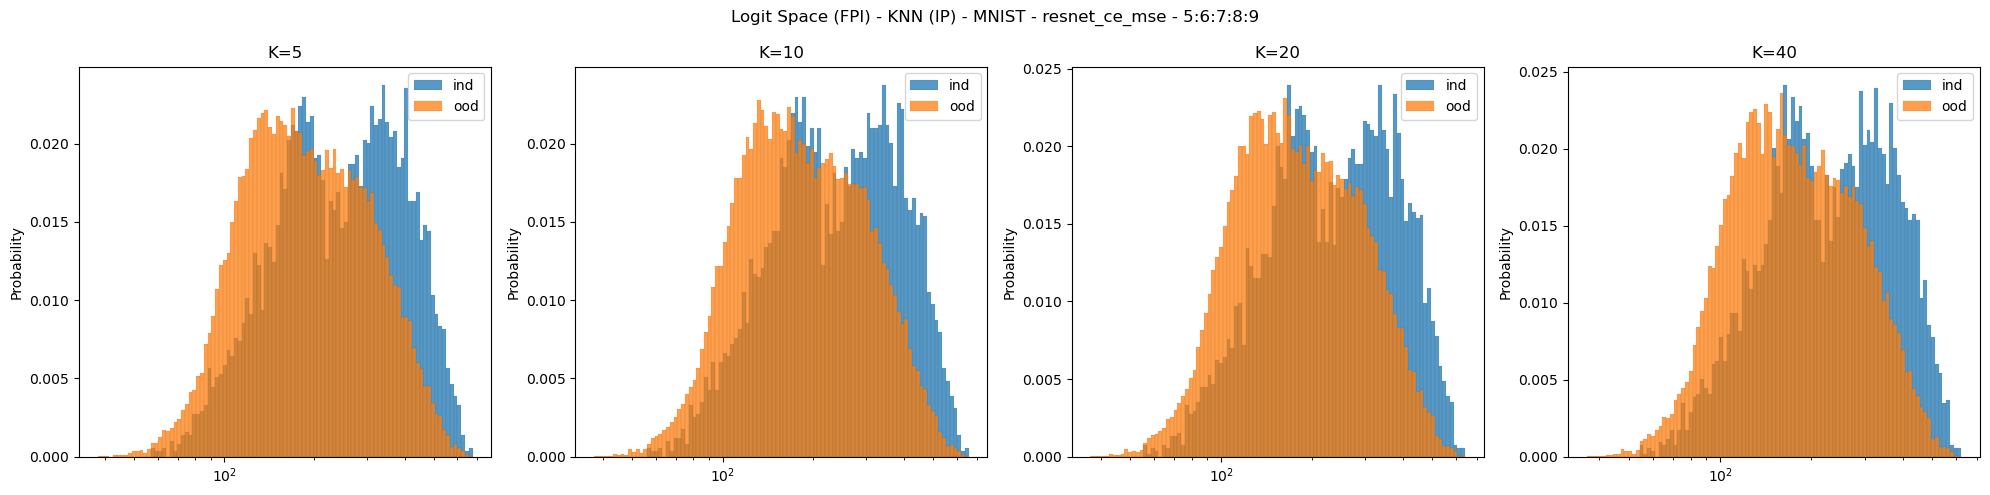

In [19]:
# check knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:01,  2.65it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  2.51it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  2.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.03it/s]

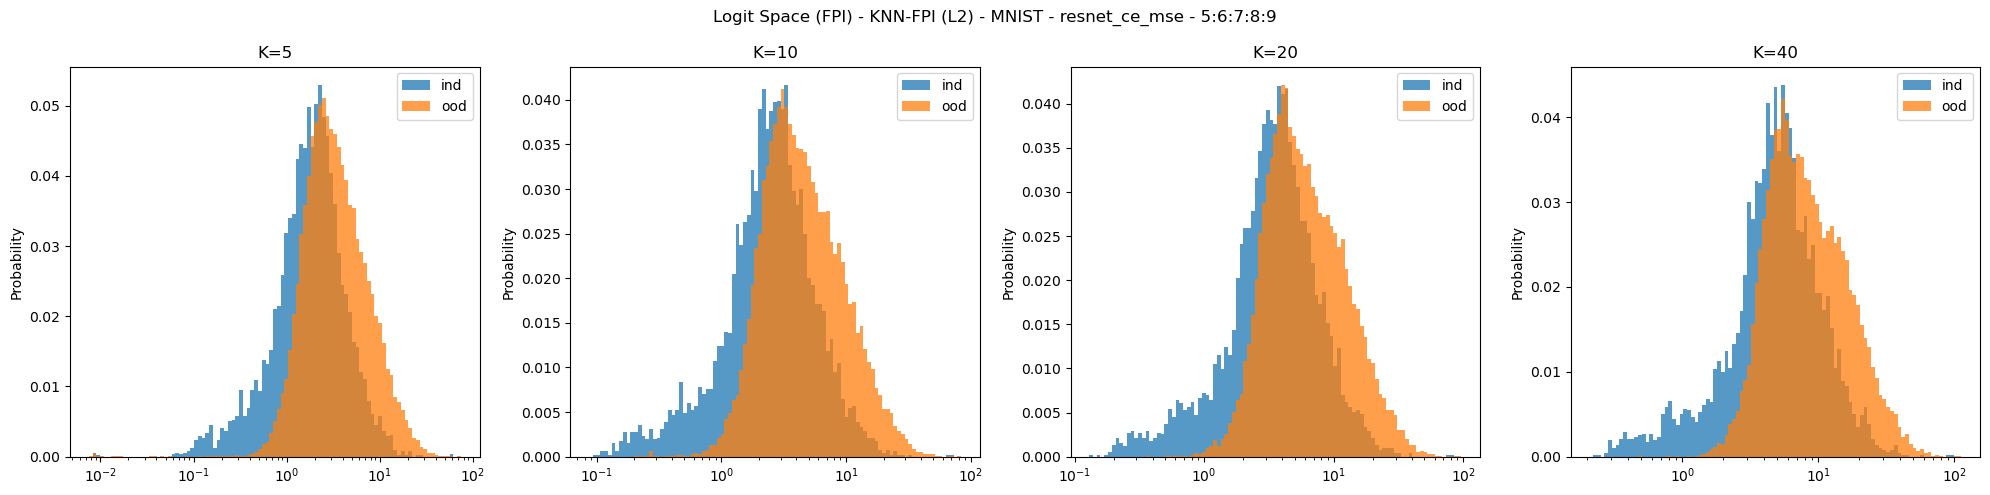

In [20]:
# check knn to val data FPI in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:01,  2.92it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  2.72it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:01<00:00,  2.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  1.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.15it/s]

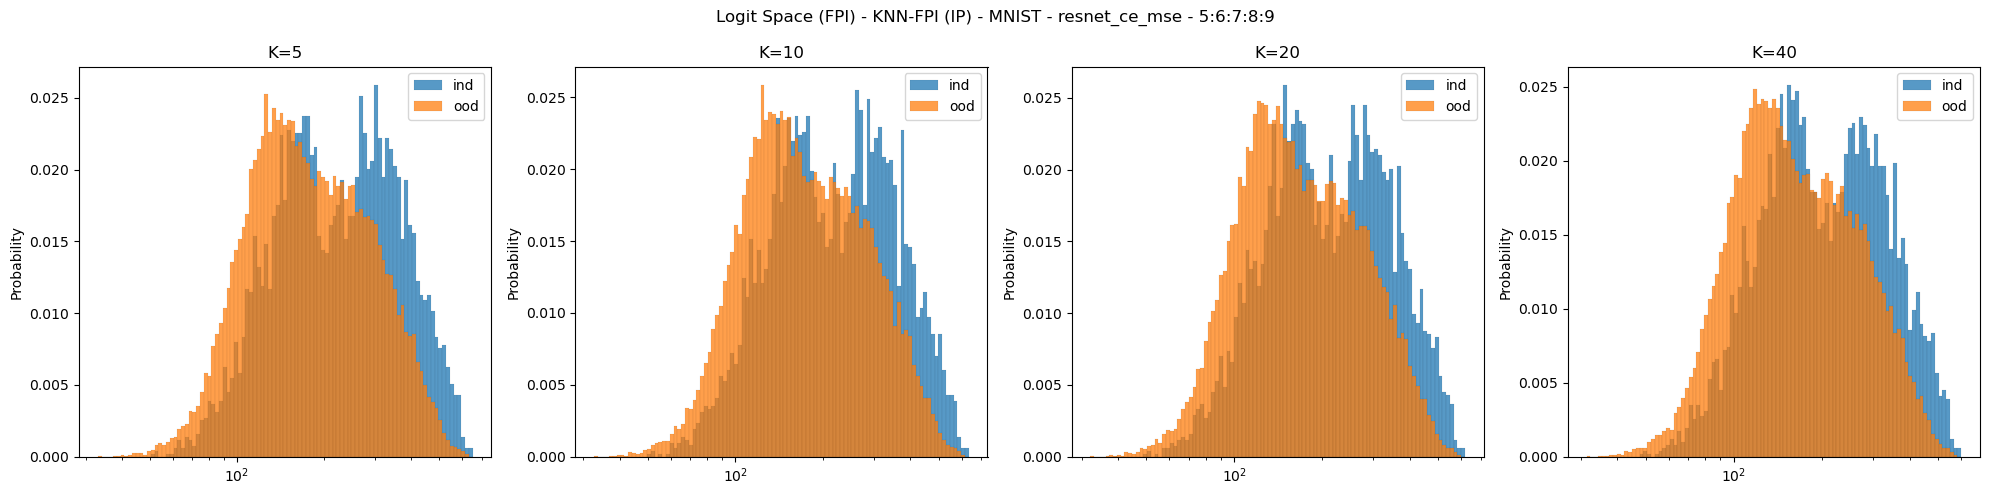

In [21]:
# check knn to val data FPI in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

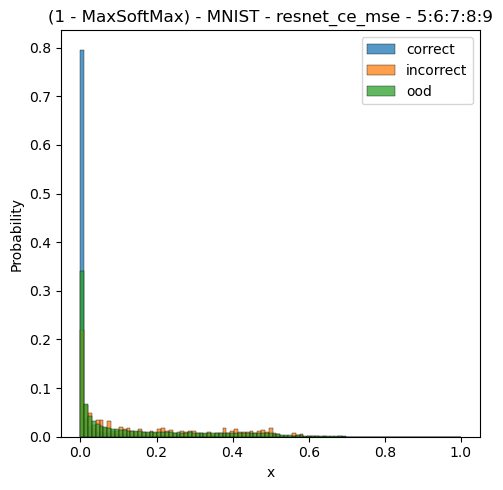

In [22]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

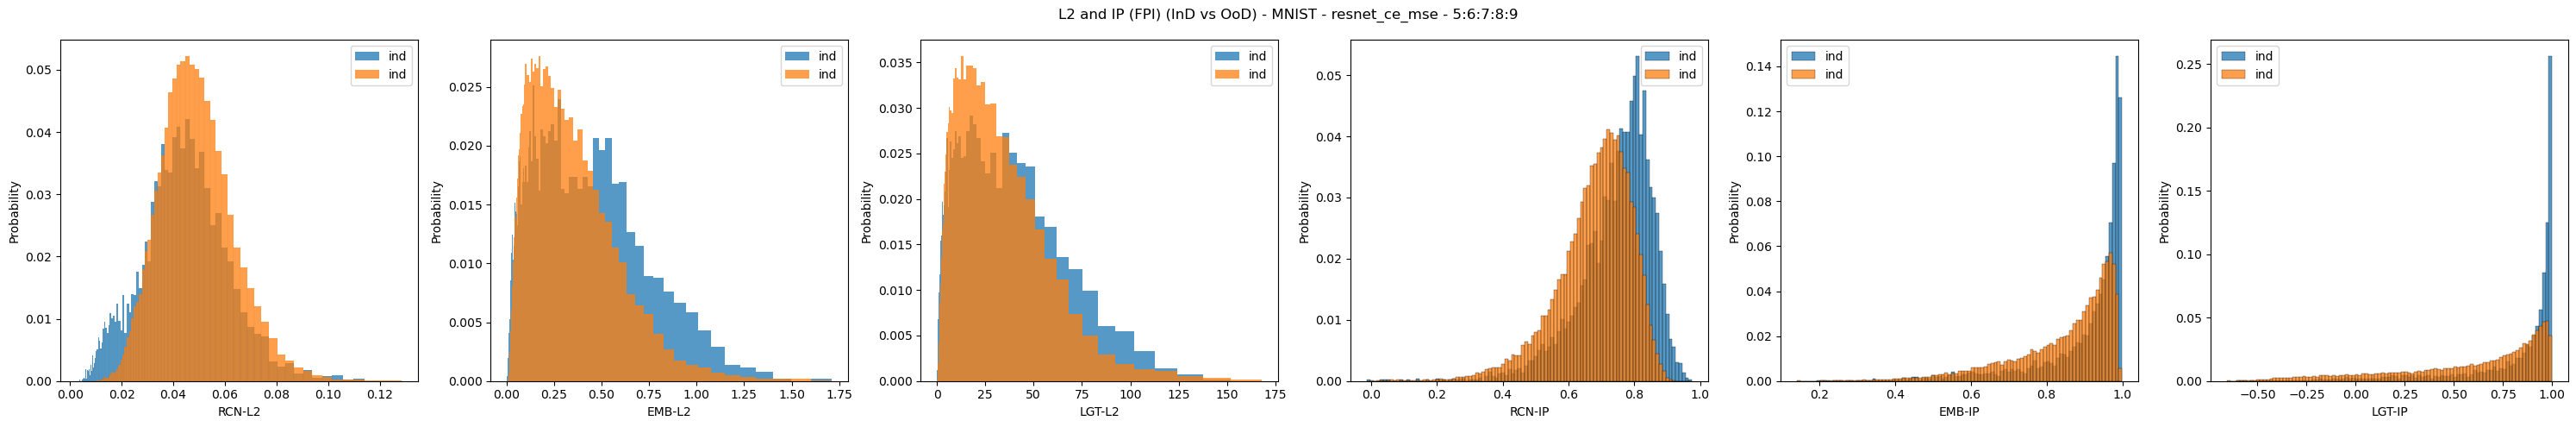

In [23]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_emb = ind_emb.reshape(si)
_ind_lgt = ind_lgt.reshape(si)
_ind_rcn_fpi = ind_rcn_fpi.reshape(si)
_ind_emb_fpi = ind_emb_fpi.reshape(si)
_ind_lgt_fpi = ind_lgt_fpi.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
_ind_emb_unit = _ind_emb / (np.linalg.norm(_ind_emb, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_unit = _ind_lgt / (np.linalg.norm(_ind_lgt, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_fpi_unit = _ind_rcn_fpi / (np.linalg.norm(_ind_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_emb_fpi_unit = _ind_emb_fpi / (np.linalg.norm(_ind_emb_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_fpi_unit = _ind_lgt_fpi / (np.linalg.norm(_ind_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)
# store
_df = pd.DataFrame(dict(
    target=ind_tgt,
    rcn_l2=ind_rcn_l2_fpi,
    emb_l2=ind_emb_l2_fpi,
    lgt_l2=ind_lgt_l2_fpi,
    rcn_ip=ind_rcn_ip_fpi,
    emb_ip=ind_emb_ip_fpi,
    lgt_ip=ind_lgt_ip_fpi,
    source="ind",
))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_emb = ood_emb.reshape(so)
    _ood_lgt = ood_lgt.reshape(so)
    _ood_rcn_fpi = ood_rcn_fpi.reshape(so)
    _ood_emb_fpi = ood_emb_fpi.reshape(so)
    _ood_lgt_fpi = ood_lgt_fpi.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_unit = _ood_emb / (np.linalg.norm(_ood_emb, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_unit = _ood_lgt / (np.linalg.norm(_ood_lgt, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_fpi_unit = _ood_rcn_fpi / (np.linalg.norm(_ood_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_fpi_unit = _ood_emb_fpi / (np.linalg.norm(_ood_emb_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_fpi_unit = _ood_lgt_fpi / (np.linalg.norm(_ood_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(
        target=ood_tgt,
        rcn_l2=ood_rcn_l2_fpi,
        emb_l2=ood_emb_l2_fpi,
        lgt_l2=ood_lgt_l2_fpi,
        rcn_ip=ood_rcn_ip_fpi,
        emb_ip=ood_emb_ip_fpi,
        lgt_ip=ood_lgt_ip_fpi,
        source="ood",
    ))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_emb_l2 = np.logspace(np.log10(df_rstat['emb_l2'].min() + 1e-7), np.log10(df_rstat['emb_l2'].max()), 100)
bins_lgt_l2 = np.logspace(np.log10(df_rstat['lgt_l2'].min() + 1e-7), np.log10(df_rstat['lgt_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
bins_emb_ip = np.linspace(df_rstat['emb_ip'].min(), df_rstat['emb_ip'].max(), 100)
bins_lgt_ip = np.linspace(df_rstat['lgt_ip'].min(), df_rstat['lgt_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax1.set_xlabel("RCN-L2")
ax2.set_xlabel("EMB-L2")
ax3.set_xlabel("LGT-L2")
ax4.set_xlabel("RCN-IP")
ax5.set_xlabel("EMB-IP")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()